# Moist Static Energy Difference Analysis
This notebook evaluates whether the assumption that the difference between the surface and free troposphere MSE, $\epsilon = h - h_{FT}$ varies as the climate warms in the same way for the mean summer day as the temperature percentile $x$ day.

I.e. it evaluates to what extent the assumption of $\delta \epsilon_x = \delta \overline{\epsilon}$ is valid.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-02-02 16:25:23,266 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset, `ds_quant`, for tropics averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the summer.

In [57]:
# Get data set averaged over all summer days in extratropics.
# Do this for each optical depth value
use_time_start = 360*2
lat_min = 30
lat_max = 60

ds_summer = []
for i in tqdm(range(n_exp)):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
    ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
    # Combine hemispheres and average over longitude, time and latitude.
    ds_use = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat').mean(dim='lat')
    ds_summer += [ds_use]
    # ds_summer[i].load()     # Load in averaged dataset so later computation and conversion to numpy is much quicker

100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


In [58]:
# Get data set averaged over all days exceeding given quantile of near surface temperature in extratropics.
# Do this for each optical depth value
quantiles_use = [90, 95, 99]
n_quant = len(quantiles_use)
temp_quant_av = np.zeros(n_exp)
ds_quant = [[] for _ in range(n_exp)]
for i in tqdm(range(n_exp)):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)    # Only latitude region
    # Collapse to single coordinate and then take quantile over it
    ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
    # quantile_thresh = np.quantile(ds_use.temp[-1].to_numpy(), quantile/100)
    for j in range(n_quant):
        quantile_thresh = ds_use.temp[-1].quantile(quantiles_use[j]/100, dim='lon_lat_time', keep_attrs=True)
        # Average each variable in data over days where near surface temperature exceeds this quantile
        ds_use2 = ds_use.where(ds_use.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
        ds_quant[i] += [ds_use2]
        #ds_quant[i].load()  # Load in averaged dataset so later computation and conversion to numpy is much quicker


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


In [59]:
# Compute the surface and saturation free troposphere MSE for the mean day
pressure_ft = 700
def mse_ft(dataset):
    # Calculate free troposphere saturated MSE for a given dataset in kJ/kg
    ds_use = dataset.sel(pfull=pressure_ft, method='nearest')
    pressure_ft_actual = ds_use.pfull * 100     # This is the pressure level closest to pressure_ft
    mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), pressure_ft_actual)
    sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
    return moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)

def mse_surface(dataset):
    return moist_static_energy(dataset.temp[-1], dataset.sphum[-1], dataset.height[-1])

temp_mean = np.zeros(n_exp)
mse_mean = np.zeros(n_exp)
mse_ft_mean = np.zeros(n_exp)

for i in tqdm(range(n_exp)):
    temp_mean[i] = ds_summer[i].temp[-1]
    mse_mean[i] = mse_surface(ds_summer[i])
    mse_ft_mean[i] = mse_ft(ds_summer[i])

100%|██████████| 7/7 [00:52<00:00,  7.54s/it]


In [60]:
# Compute the surface and saturation free troposphere MSE for the quantile days
temp_quant = np.zeros((n_exp, n_quant))
mse_quant = np.zeros((n_exp, n_quant))
mse_ft_quant = np.zeros((n_exp, n_quant))
for i in tqdm(range(n_exp)):
    for j in range(n_quant):
        temp_quant[i, j] = ds_quant[i][j].temp[-1]
        mse_quant[i, j] = mse_surface(ds_quant[i][j])
        mse_ft_quant[i, j] = mse_ft(ds_quant[i][j])

100%|██████████| 7/7 [06:55<00:00, 59.36s/it]


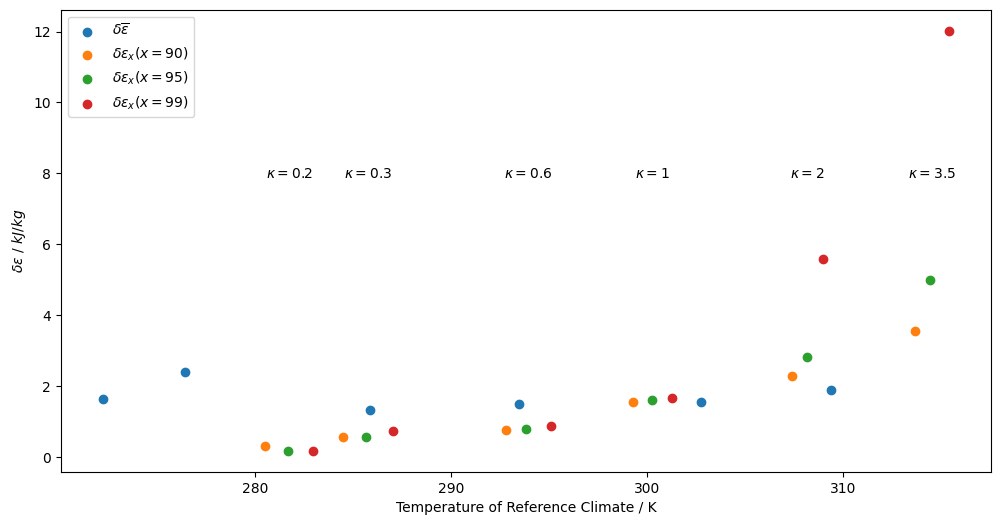

In [64]:
# Compute epsilon values indicating the difference between the surface MSE and free trop MSE
epsilon_mean = mse_mean - mse_ft_mean
epsilon_quant = mse_quant - mse_ft_quant
delta_epsilon_quant = np.zeros((n_exp-1, n_quant))
for j in range(n_quant):
    delta_epsilon_quant[:, j] = np.ediff1d(epsilon_quant[:, j])
delta_epsilon_mean = np.ediff1d(epsilon_mean)

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.scatter(temp_mean[:-1], delta_epsilon_mean, label='$\delta \overline{\epsilon}$')
for j in range(n_quant):
    ax.scatter(temp_quant[:-1, j], delta_epsilon_quant[:, j], label=f'$\delta \epsilon_x(x={quantiles_use[j]})$')
for i in range(n_exp-1):
    ax.text(np.mean([temp_quant[i, 0], temp_quant[i, -1]]), 8, f'$\kappa = {tau_lw[i]}$', ha='center', va='center')
ax.legend()
ax.set_xlabel('Temperature of Reference Climate / K')
ax.set_ylabel('$\delta \epsilon$ / $kJ/kg$');

### Tropics - $0 < |\phi| < 20$
From this plot, it seems that the assumption of $\delta \epsilon_x = \delta \overline{\epsilon}$ is approximately valid for the reference climate closest to Earth ($\kappa=1$) but not for any other climate.

Also, for the $\kappa=0.2, 0.3, 2, 3.5$ climates, there is a clear trend that $\delta \epsilon_x$ is larger than $\delta \overline{\epsilon}$ and increases with $x$.

### Extratropics - $30 < |\phi| < 60$
In the extratropics, it seems that $\delta \epsilon_x = \delta \overline{\epsilon}$ is approximately valid for the reference climate closest to Earth ($\kappa=1$).

For colder climates ($\kappa < 1$), it seems that $\delta \overline{\epsilon}$ is greater than $\delta \epsilon_x$ with the latter staying fairly constant as $x$ varies.

For warmer climates ($\kappa > 1$), it seems that $\delta \epsilon_x$ is larger than $\delta \overline{\epsilon}$ and increases with $x$.